In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/staticData.csv', names=['x1', 'y1','z1','x2', 'y2','z2','x1_rotacion','y1_rotacion','z1_rotacion','x2_rotacion','y2_rotacion','z2_rotacion', 'direccion','velocidad'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,x1,y1,z1,x2,y2,z2,x1_rotacion,y1_rotacion,z1_rotacion,x2_rotacion,y2_rotacion,z2_rotacion,direccion,velocidad
0,0.318429,-0.126893,3.979163,-0.837971,1.922544,9.732430,4.572977,-1.820686,85.076471,-4.828231,11.134181,77.839357,1,0.100000
1,0.246603,-3.969586,1.450886,-1.312023,-1.738190,9.955091,3.339297,-69.658119,20.041836,-7.397332,-9.820932,77.660363,1,74.407334
2,0.421379,-0.371101,4.027047,-1.067814,-2.600103,9.974244,5.948517,-5.236632,82.062367,-5.914463,-14.531304,74.261698,1,0.000000
3,-0.359130,2.140416,3.201048,-0.694318,-1.513135,10.041282,-5.328164,33.603732,55.862420,-3.911479,-8.549397,80.586083,1,-58.138280
4,0.258574,-0.545878,4.103662,-0.569820,-1.798045,10.101137,3.574069,-7.562302,81.626695,-3.178853,-10.077484,79.423017,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,0.155623,-3.579331,2.152387,7.551312,-1.611298,7.589619,2.133870,-58.913908,30.996195,44.223645,-8.558787,44.507214,0,68.634983
1019,-0.031125,-0.090980,4.891354,-1.053449,0.004788,10.074801,-0.364516,-1.065563,88.873800,-5.969311,0.027084,84.030627,1,0.000000
1020,0.203507,2.449268,3.191471,8.789114,-2.267309,7.929596,2.895902,37.448011,52.400620,46.821324,-10.842867,41.140674,0,-69.726869
1021,-0.045490,2.980781,2.806004,6.880936,-0.639252,7.577648,-0.636647,46.726206,43.266707,42.140145,-3.573687,47.636215,1,0.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = df[['x1', 'y1','z1','x2', 'y2','z2','x1_rotacion','y1_rotacion','z1_rotacion','x2_rotacion','y2_rotacion','z2_rotacion']].values

In [ ]:
label_encoder = LabelEncoder()
df['direccion'] = label_encoder.fit_transform(df['direccion'])

In [ ]:
#se añade padding a los datos de entrada para que el tamaño total por muestra sea 3072
data_padded = np.pad(data, ((0, 0), (0, 3072 - 12)), mode='constant')
data_padded.shape

(1023, 3072)

In [ ]:
#Se cambia la forma de los datos para que sea compatible con redes convoluconales
#num_samples = data_padded.shape[0]
X_image = data_padded.reshape(-1, 32, 32, 3)

In [ ]:
print("Forma de X_image después de repetición:", X_image.shape) # 1023 filas, imágenes de 32x32 en 3 canales

Forma de X_image después de repetición: (1023, 32, 32, 3)


In [ ]:
# Separar las salidas: dirección (categorías) y velocidad (continuo)
y_direction = df['direccion'].values  # Columna con etiquetas de dirección
y_speed = df['velocidad'].values     # Columna con valores de velocidad

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Cargar MobileNet sin las capas finales (top=False)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Agregar nuevas capas para la predicción de dirección y velocidad
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Agregar una capa de pooling global
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x) #capa de regularización para el intento 2
x = Dropout(0.5)(x)  # Dropout del 50% para el intento 2
direction_output = Dense(3, activation='softmax', name='direction')(x)  # Predicción de dirección
speed_output = Dense(1, activation='linear', name='speed')(x)  # Predicción de velocidad

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=[direction_output, speed_output])

# Congelar las capas base para evitar que se entrenen
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss={'direction': 'sparse_categorical_crossentropy', 'speed': 'mse'},
    metrics={'direction': 'accuracy', 'speed': 'mae'})

# Ver resumen del modelo
model.summary()


<ipython-input-28-41fd3f76d508>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 32)     │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 16, 16, 32)     │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 16, 16, 32)     │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 16, 16, 32)     │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 16, 16, 64)     │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 16, 16, 64)     │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 16, 16, 64)     │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 17, 17, 64)     │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 8, 8, 64)       │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 8, 8, 64)       │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 8, 8, 64)       │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 8, 8, 128)      │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn         

 Total params: 5,332,164 (20.34 MB)

 Trainable params: 2,103,300 (8.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train_image, X_test_image, y_train_direction, y_test_direction, y_train_speed, y_test_speed = train_test_split(
    X_image,
    y_direction,
    y_speed,
    test_size=0.2,
    random_state=42
)

In [ ]:
history = model.fit(
    X_train_image,
    {'direction': y_train_direction, 'speed': y_train_speed},  # Salidas
    validation_split=0.2,  # 20% de los datos para validación
    epochs=50,
    batch_size=32
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - direction_accuracy: 0.5506 - direction_loss: 1.0573 - loss: 2570.5649 - speed_loss: 2557.9363 - speed_mae: 34.4691 - val_direction_accuracy: 0.7622 - val_direction_loss: 0.9674 - val_loss: 1954.4398 - val_speed_loss: 1839.7618 - val_speed_mae: 26.3364
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - direction_accuracy: 0.7059 - direction_loss: 0.9744 - loss: 2333.5671 - speed_loss: 2322.0725 - speed_mae: 31.3044 - val_direction_accuracy: 0.7622 - val_direction_loss: 0.8925 - val_loss: 1950.1873 - val_speed_loss: 1835.7026 - val_speed_mae: 26.4419
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - direction_accuracy: 0.7126 - direction_loss: 0.9144 - loss: 2379.5505 - speed_loss: 2369.6208 - speed_mae: 32.2406 - val_direction_accuracy: 0.7622 - val_direction_loss: 0.8378 - val_loss: 1946.9928 - val_speed_loss: 1833.1240 - val_speed_mae: 26.4708
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - direction_accuracy: 0.6935 - d

In [ ]:
# Evaluar el modelo
results = model.evaluate(X_test_image, {'direction': y_test_direction, 'speed': y_test_speed})

# Mostrar resultados
print("Pérdida total:", results[0])  # Pérdida combinada
print("Pérdida de dirección:", results[1])  # Pérdida de dirección
print("Pérdida de velocidad:", results[2])  # Pérdida de velocidad


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - direction_accuracy: 0.7178 - direction_loss: 0.7832 - loss: 1730.6305 - speed_loss: 1716.9983 - speed_mae: 30.6601
Pérdida total: 1697.6171875
Pérdida de dirección: 0.796098530292511
Pérdida de velocidad: 1671.5364990234375


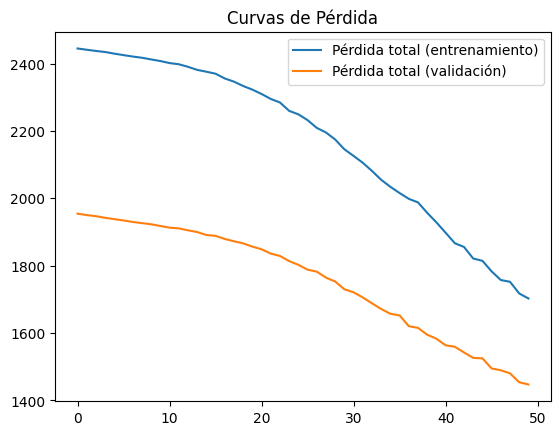

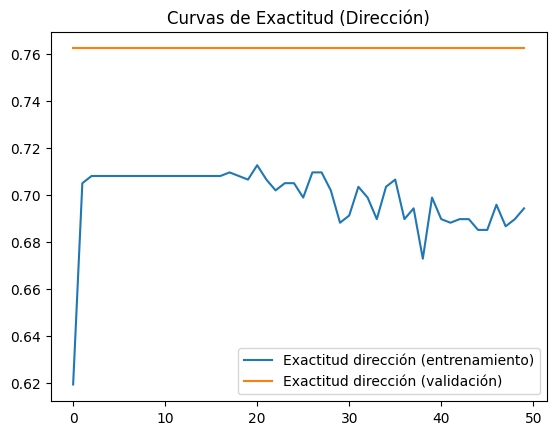

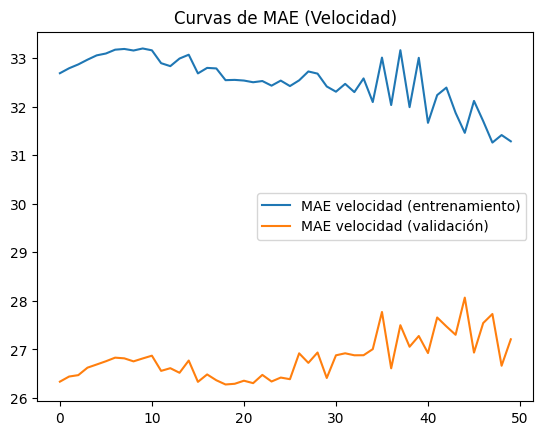

In [ ]:
import matplotlib.pyplot as plt

# Pérdida
plt.plot(history.history['loss'], label='Pérdida total (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida total (validación)')
plt.legend()
plt.title('Curvas de Pérdida')
plt.show()

# MAE de dirección
plt.plot(history.history['direction_accuracy'], label='Exactitud dirección (entrenamiento)')
plt.plot(history.history['val_direction_accuracy'], label='Exactitud dirección (validación)')
plt.legend()
plt.title('Curvas de Exactitud (Dirección)')
plt.show()

# Error absoluto de velocidad
plt.plot(history.history['speed_mae'], label='MAE velocidad (entrenamiento)')
plt.plot(history.history['val_speed_mae'], label='MAE velocidad (validación)')
plt.legend()
plt.title('Curvas de MAE (Velocidad)')
plt.show()
